In [ ]:
from PIL import Image
import requests
from transformers import AutoModelForCausalLM, AutoProcessor, BitsAndBytesConfig
import torch
from IPython.display import display
import time


# Define model ID
#model_id = "microsoft/Phi-3-vision-128k-instruct"
model_id = "microsoft/Phi-3.5-vision-instruct"
#model_id = "microsoft/phi-4"

# Load processor
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

# Define BitsAndBytes configuration for 4-bit quantization
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load model with 4-bit quantization and map to CUDA
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda",
    trust_remote_code=True,
    torch_dtype="auto",
    quantization_config=nf4_config,
    _attn_implementation='eager') # use _attn_implementation='eager' to disable flash attention

c:\Users\Andrea.Bagante\AppData\Local\pypoetry\Cache\virtualenvs\id-models-comparison-B_ZlXsb4-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 6/6 [00:21<00:00,  3.61s/it]


In [4]:
def model_inference(messages, path_image):
    
    start_time = time.time()
    
    image = Image.open(path_image)

    # Prepare prompt with image token
    # prompt = processor.tokenizer.apply_chat_template(
    #     messages, tokenize=False, add_generation_prompt=True
    # )
    prompt = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # Process prompt and image for model input
    inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

    # Generate text response using model
    generate_ids = model.generate(
        **inputs,
        eos_token_id=processor.tokenizer.eos_token_id,
        max_new_tokens=500,
        do_sample=False,
        temperature=0.0,
        use_cache=False,
    )

    # Remove input tokens from generated response
    generate_ids = generate_ids[:, inputs["input_ids"].shape[1] :]

    # Decode generated IDs to text
    response = processor.batch_decode(
        generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]


    #display(image)
    end_time = time.time()
    print("Inference time: {}".format(end_time - start_time))

    # Print the generated response
    print(response)

In [5]:
prompt_cie_front = [{"role": "user", "content": "<|image_1|>\nOCR the text of the image. Extract the text of the following fields and put it in a JSON format: \
            'Cognome', 'Nome', 'Nato il', 'a',\
            'Cittadinanza', 'Residenza', 'Via',\
            'Stato civile', 'Professione', 'Statura'.\
            Respond only with valid JSON. Do not write an introduction or summary"}]

#path_image = "C:\\Users\\Andrea.Bagante\\Desktop\\CI_cartacea\\20241212_160419.jpg" # fronte
path_image = "C:\\Users\\Andrea.Bagante\\Desktop\\CI_cartacea\\20241212_160455.jpg" # retro

# inference
model_inference(prompt_cie_front, path_image)

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
# 3.5 
# ```json
# {
#   "Cognome": "BOGGIAN",
#   "Nome": "STEFANO",
#   "Nato il": "21/08/1979",
#   "a": "2.258",
#   "Cittadinanza": "ITALIANA",
#   "Residenza": "ABANO TERME(PD)",
#   "Via": "CASSINO Num. 11",
#   "Stato civile": "CONIUGATO",
#   "Professione": "INGERE",
#   "Statura": "190 cm"
# }
# ```


In [6]:
from enum import Enum

class DocumentROIs(Enum):
    
    CARTA_IDENTITA_CARTACEA = {
        "cognome": [(50, 50, 300, 40)],
        "nome": [(50, 80, 300, 40)],
        "data_nascita" : [(50, 110, 300, 40)],
        "luogo_nascita": [(50, 170, 300, 40)],
        "cittadinanza": [(50, 200, 400, 40)],
        "residenza_citta": [(50, 235, 400, 40)],
        "residenza_via": [(50, 270, 400, 40)],
        "stato_civile": [(50, 300, 300, 40)],
        "professione": [(50, 330, 300, 40)],
        "altezza": [(150, 400, 200, 40)],
        "capelli": [(150, 440, 200, 40)],
        "occhi": [(150, 470, 300, 40)],
        # "segni_particolari": [(70, 510, 350, 150)]
}

In [7]:
import cv2
import numpy as np

def preprocessing(image_path):
    original_image = cv2.imread(image_path)

    (H, W) = original_image.shape[:2]
    # Necessario fare resize se l'immagine supera determinati valori, altrimenti ritorna "unknown C## error"
    if H > 2000 or W > 1500:
        if H > 2000:
            H = 2000
        if W > 1500:
            W = 1500
        try:
             preprocessed_image = cv2.resize(original_image, [W, H], interpolation=cv2.INTER_CUBIC)
        except Exception as ex:
             raise Exception(str(ex))
    else:
        preprocessed_image = original_image

    return preprocessed_image

In [8]:
def base_alignement(image):

    ref_image_path = "C:\\codice\\gitgit\\ai-id-extractor\\app\\classes\\extractor\\resources\\ref_carta_identita_cartacea.jpg"
    reference_image = cv2.imread(ref_image_path)

    reference = cv2.resize(reference_image, [986, 657], interpolation=cv2.INTER_CUBIC)
    reference = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)

    image_to_move = cv2.resize(image, [986, 657], interpolation=cv2.INTER_CUBIC)
    image_to_move = cv2.cvtColor(image_to_move, cv2.COLOR_BGR2GRAY)

    # Rileva i punti chiave e descrittori usando SIFT
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(reference, None)
    kp2, des2 = sift.detectAndCompute(image_to_move, None)

    # Usa FLANN per trovare le corrispondenze tra i punti chiave
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # Filtra le corrispondenze usando il rapporto di Lowe
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)

    # Estrae le coordinate dei punti chiave corrispondenti
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

    # Calcola la matrice di omografia
    M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Applica la trasformazione all'immagine
    h, w= reference.shape
    aligned_img = cv2.warpPerspective(image_to_move, M, (w, h))

    return aligned_img


In [9]:
def save_temp_image(image, temp_image_path):
    cv2.imwrite(temp_image_path, image)

In [10]:
image_path = "C:\\Users\\Andrea.Bagante\\Desktop\\CI_cartacea\\CI_Stefano_ok.jpg"
image = preprocessing(image_path)

In [13]:
def model_inference(messages, path_image):
    
    start_time = time.time()
    
    image = Image.open(path_image)

    # Prepare prompt with image token
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # Process prompt and image for model input
    inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

    # Generate text response using model
    generate_ids = model.generate(
        **inputs,
        eos_token_id=processor.tokenizer.eos_token_id,
        max_new_tokens=500,
        do_sample=False,
        # temperature=0.0,
        use_cache=False,
    )

    # Remove input tokens from generated response
    generate_ids = generate_ids[:, inputs["input_ids"].shape[1] :]

    # Decode generated IDs to text
    response = processor.batch_decode(
        generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]


    display(image)
    end_time = time.time()
    print("Inference time: {}".format(end_time - start_time))

    # Print the generated response
    print(response)

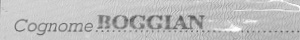

Inference time: 2.048197031021118
Cognome ROGLIAN
None


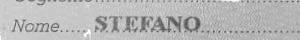

Inference time: 2.914576292037964

Nome... STEFANO


None


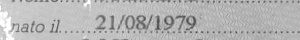

Inference time: 2.700218677520752
21/08/1979
None


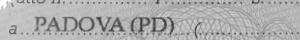

Inference time: 1.8725056648254395
PADOVA (PD)
None


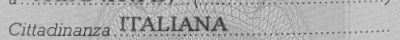

Inference time: 2.514939785003662
Cittadinanza ITALIANA
None


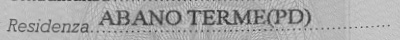

Inference time: 3.0929219722747803
Residenza. ABANO TERME(PD)
None


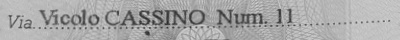

Inference time: 3.3255879878997803
Via.Vicolo CASSINO Num. 11
None


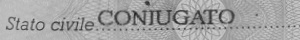

Inference time: 2.0893070697784424
Stato civile CONIUGATO
None


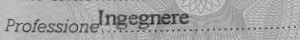

Inference time: 7.918705224990845

Professione...
Ingegnere
Professione...
Ingegnere
Professione...
Ingegnere

None


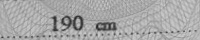

Inference time: 1.457589864730835
190 cm
None


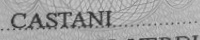

Inference time: 1.0463128089904785
CASTAN
None


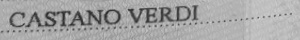

Inference time: 1.8805675506591797
CASTANO VERDI
None


In [14]:
from tempfile import mkstemp
import os

temp_image_path = None
aligned_image = base_alignement(image)
v = getattr(DocumentROIs, "CARTA_IDENTITA_CARTACEA").value
for name, roi in v.items():
    x, y, w, h = roi[0]
    roi_image = aligned_image[y:y+h, x:x+w]

    # cv2.imshow('image', roi_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    temp_file, temp_image_path = mkstemp(suffix=".jpg")
    with os.fdopen(temp_file, "wb") as f:
        save_temp_image(roi_image, temp_image_path)
        message = [{"role": "user", "content": "<|image_1|>\nAct as an OCR. OCR the text of the image. \
            1. Recognize all visible text in the image as accurately as possible. \
            2. Maintain the original structure and formatting of the text. \
            3. If any words or phrases are unclear, indicate this with [unclear] in your transcription. \
            4. Provide only the transcription without any additional comments. Just write the transcription, no comments or other text! \
            5. Remember to DO NOT add any other text or comment other than the transcription!"}]

        result = model_inference(message, temp_image_path)
        print(result)